This note book executes the following steps on the MIMIC dataset:
1. Load patient, drug, disease embeddings from NCMF and DFMF
2. Load ICUSTAYS.csv and ADMISSIONS.csv from the original MIMIC III dataset
3. Make k clusters of the patient embeddings from the above csv files
4. Choose top e entities that are relevant in each cluster (eg: top diagnosis or top insurance schemes etc)
5. Plt distribution of entities in each cluster
6. Calculate silhouette score and ARI score
7. Visualize clusters using hypertools
8. Visualize groups based on existing labels

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
patient_clusters = 3
tope = 5

#### Step 1 - Load patient, drug, disease embeddings from NCMF and DFMF

In [3]:
def load(emb_file_path):
    emb_dict = {}
    with open(emb_file_path, 'r') as emb_file:
        for i, line in enumerate(emb_file):
            if i == 0:
                train_para = line[:-1]
            else:
                index, emb = line[:-1].split('\t')
                emb_dict[index] = np.array(emb.split()).astype(np.float32)

    return train_para, emb_dict

In [4]:
ncmf_emb_file = "../datasets/NCMF/MIMIC/emb_sample_1.dat"
dfmf_emb_file = "../scikit-fusion/experiments/dfmf_s1_emb_MIMIC.dat"
dcmf_emb_file = "../DCMF/experiments/emb_MIMIC_sample_1.dat"
cmf_emb_file = "../CMF/experiments/cmf_s1_MIMIC_emb.dat"
gcmf_emb_file = "../CMF/experiments/gcmf_s1_emb_MIMIC.dat"

In [5]:
train_para, emb_dict = load(ncmf_emb_file)

In [6]:
train_para_dfmf, emb_dict_dfmf = load(dfmf_emb_file)

In [7]:
train_para_dcmf, emb_dict_dcmf = load(dcmf_emb_file)
train_para_cmf, emb_dict_cmf = load(cmf_emb_file)
train_para_gcmf, emb_dict_gcmf = load(gcmf_emb_file)

In [8]:
print(emb_dict_dcmf['0'].shape)
print(emb_dict_cmf['0'].shape)
print(emb_dict_gcmf['0'].shape)

(100,)
(50,)
(50,)


#### Step 2 - Load ICUSTAYS.csv and ADMISSIONS.csv from the original MIMIC III dataset

In [9]:
# get patient SUBJECT_ID to embedding index mapping
fname_data = "./dict_nsides_mimic_data_v1_case1_part.pkl"
data = pkl.load(open(fname_data,"rb"))
patient_subjectID2embidx_map = data["metadata"]["dict_p_id_idx_map"]

In [10]:
patient_subjectID2embidx_map

{11: 0,
 38: 1,
 41: 2,
 43: 3,
 61: 4,
 87: 5,
 92: 6,
 93: 7,
 96: 8,
 97: 9,
 109: 10,
 115: 11,
 117: 12,
 124: 13,
 126: 14,
 129: 15,
 139: 16,
 145: 17,
 147: 18,
 148: 19,
 165: 20,
 177: 21,
 182: 22,
 188: 23,
 195: 24,
 214: 25,
 236: 26,
 245: 27,
 283: 28,
 284: 29,
 286: 30,
 298: 31,
 301: 32,
 305: 33,
 314: 34,
 330: 35,
 339: 36,
 352: 37,
 357: 38,
 369: 39,
 371: 40,
 372: 41,
 373: 42,
 376: 43,
 384: 44,
 393: 45,
 405: 46,
 419: 47,
 423: 48,
 428: 49,
 433: 50,
 437: 51,
 441: 52,
 445: 53,
 454: 54,
 457: 55,
 461: 56,
 471: 57,
 473: 58,
 487: 59,
 507: 60,
 517: 61,
 518: 62,
 533: 63,
 534: 64,
 540: 65,
 544: 66,
 546: 67,
 584: 68,
 587: 69,
 608: 70,
 610: 71,
 624: 72,
 632: 73,
 634: 74,
 642: 75,
 652: 76,
 656: 77,
 665: 78,
 677: 79,
 685: 80,
 689: 81,
 708: 82,
 720: 83,
 732: 84,
 741: 85,
 743: 86,
 745: 87,
 755: 88,
 759: 89,
 765: 90,
 768: 91,
 773: 92,
 775: 93,
 801: 94,
 804: 95,
 822: 96,
 827: 97,
 858: 98,
 862: 99,
 873: 100,
 877: 101

In [12]:
icustays_df = pd.read_csv("./ICUSTAYS.csv")
print(icustays_df.shape)
icustays_df.head()

(61532, 12)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,365,268,110404,280836,carevue,MICU,MICU,52,52,2198-02-14 23:27:38,2198-02-18 05:26:11,3.2490
1,366,269,106296,206613,carevue,MICU,MICU,52,52,2170-11-05 11:05:29,2170-11-08 17:46:57,3.2788
2,367,270,188028,220345,carevue,CCU,CCU,57,57,2128-06-24 15:05:20,2128-06-27 12:32:29,2.8939
3,368,271,173727,249196,carevue,MICU,SICU,52,23,2120-08-07 23:12:42,2120-08-10 00:39:04,2.0600
4,369,272,164716,210407,carevue,CCU,CCU,57,57,2186-12-25 21:08:04,2186-12-27 12:01:13,1.6202


In [13]:
icustays_df = icustays_df[icustays_df.SUBJECT_ID.isin(list(patient_subjectID2embidx_map.keys()))]

In [14]:
icustays_df = icustays_df.drop_duplicates("SUBJECT_ID")
icustays_df.shape

(5890, 12)

In [15]:
icustays_df["patient_emb_idx"] = icustays_df["SUBJECT_ID"].apply(lambda x: patient_subjectID2embidx_map[x])
icustays_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,patient_emb_idx
14,379,283,109185,231490,carevue,MICU,MICU,15,15,2166-08-12 22:03:26,2166-09-12 14:41:42,30.6932,28
16,381,284,112354,223593,carevue,MICU,MICU,12,12,2149-11-29 15:39:34,2149-11-30 17:18:14,1.0685,29
18,383,286,106909,260225,carevue,MICU,MICU,52,52,2175-12-31 22:57:27,2176-02-24 19:16:58,54.8469,30
33,398,298,119446,225523,carevue,MICU,MICU,52,52,2140-08-07 00:33:57,2140-08-09 06:46:53,2.2590,31
36,401,301,160332,288401,carevue,CCU,CCU,7,7,2189-11-11 12:12:33,2189-11-13 22:11:28,2.4159,32


In [16]:
admissions_df = pd.read_csv("./ADMISSIONS.csv")
print(admissions_df.shape)
admissions_df.head()

(58976, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


In [17]:
admissions_df = admissions_df[admissions_df.SUBJECT_ID.isin(list(patient_subjectID2embidx_map.keys()))]
admissions_df.shape

(9197, 19)

In [18]:
admissions_df = admissions_df.drop_duplicates("SUBJECT_ID")
admissions_df.shape

(5891, 19)

In [19]:
admissions_df["patient_emb_idx"] = admissions_df["SUBJECT_ID"].apply(lambda x: patient_subjectID2embidx_map[x])
admissions_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,patient_emb_idx
19,40,38,185910,2166-08-10 00:28:00,2166-09-04 11:30:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,LONG TERM CARE HOSPITAL,Medicare,NaN,CATHOLIC,WIDOWED,WHITE,NaN,NaN,ACUTE MYOCARDIAL INFARCTION-SEPSIS,0,1,1
21,42,41,101757,2132-12-31 10:30:00,2133-01-27 15:45:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,DISC-TRAN TO FEDERAL HC,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,RIGHT BRAIN STEM LESION/SDA,0,1,2
22,456,357,174486,2197-12-06 07:13:00,2198-01-03 14:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,NOT SPECIFIED,MARRIED,WHITE,2197-12-06 06:28:00,2197-12-06 07:43:00,GASTROINTESTINAL BLEED,0,1,38
41,475,369,145787,2142-10-09 07:15:00,2142-10-16 14:20:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,AORTIC STENOSIS\AORTIC VALVE REPLACEMENT; ? CA...,0,1,39
43,477,371,113500,2147-12-08 23:38:00,2148-01-02 11:18:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,LONG TERM CARE HOSPITAL,Government,NaN,UNOBTAINABLE,MARRIED,UNKNOWN/NOT SPECIFIED,2147-12-08 22:23:00,2147-12-09 00:36:00,STATUS POST MOTOR VEHICLE ACCIDENT WITH INJURIES,0,1,40


#### Step 3 - Map each patient to its embedding and get clusters on PCA

In [20]:
#  For CLustering and visualization
import hypertools as hyp
from sklearn.decomposition import PCA

In [21]:
pca = PCA(n_components=5, random_state=42)

##### ICU STAYS

In [22]:
icustays_df["ncmf_emb"] = icustays_df["patient_emb_idx"].apply(lambda x: emb_dict[str(x)])
icustays_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS,patient_emb_idx,ncmf_emb
14,379,283,109185,231490,carevue,MICU,MICU,15,15,2166-08-12 22:03:26,2166-09-12 14:41:42,30.6932,28,"[-0.053747416, 0.1337276, 0.20905808, 0.109576..."
16,381,284,112354,223593,carevue,MICU,MICU,12,12,2149-11-29 15:39:34,2149-11-30 17:18:14,1.0685,29,"[-0.055479467, 0.15430528, 0.18334538, 0.08863..."
18,383,286,106909,260225,carevue,MICU,MICU,52,52,2175-12-31 22:57:27,2176-02-24 19:16:58,54.8469,30,"[-0.058798995, 0.14199078, 0.2351837, 0.130794..."
33,398,298,119446,225523,carevue,MICU,MICU,52,52,2140-08-07 00:33:57,2140-08-09 06:46:53,2.2590,31,"[-0.06791707, 0.1567259, 0.18527885, 0.0866117..."
36,401,301,160332,288401,carevue,CCU,CCU,7,7,2189-11-11 12:12:33,2189-11-13 22:11:28,2.4159,32,"[-0.05809397, 0.15602477, 0.17874989, 0.108615..."


In [23]:
icustays_df[[f"emb_ncmf_{i}" for i in range(50)]] = pd.DataFrame(icustays_df.ncmf_emb.tolist(), index= icustays_df.index)
icustays_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,...,emb_ncmf_40,emb_ncmf_41,emb_ncmf_42,emb_ncmf_43,emb_ncmf_44,emb_ncmf_45,emb_ncmf_46,emb_ncmf_47,emb_ncmf_48,emb_ncmf_49
14,379,283,109185,231490,carevue,MICU,MICU,15,15,2166-08-12 22:03:26,...,0.372865,-0.076809,-0.329889,-0.267657,-0.001014,0.351336,0.166336,0.127981,0.145007,-0.176806
16,381,284,112354,223593,carevue,MICU,MICU,12,12,2149-11-29 15:39:34,...,0.380740,-0.032689,-0.354686,-0.266192,-0.010827,0.371678,0.143417,0.156963,0.187187,-0.164232
18,383,286,106909,260225,carevue,MICU,MICU,52,52,2175-12-31 22:57:27,...,0.408063,-0.045525,-0.338224,-0.290773,-0.007430,0.377357,0.173953,0.147540,0.171944,-0.176835
33,398,298,119446,225523,carevue,MICU,MICU,52,52,2140-08-07 00:33:57,...,0.366091,-0.051911,-0.338278,-0.263440,-0.002310,0.356750,0.134817,0.130951,0.154651,-0.183389
36,401,301,160332,288401,carevue,CCU,CCU,7,7,2189-11-11 12:12:33,...,0.364648,-0.070710,-0.332024,-0.284405,0.042794,0.368325,0.165263,0.141468,0.168060,-0.190302


In [24]:
icustays_df["dfmf_emb"] = icustays_df["patient_emb_idx"].apply(lambda x: emb_dict_dfmf[str(x)])
icustays_df[[f"emb_dfmf_{i}" for i in range(50)]] = pd.DataFrame(icustays_df.dfmf_emb.tolist(), index= icustays_df.index)
icustays_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,...,emb_dfmf_40,emb_dfmf_41,emb_dfmf_42,emb_dfmf_43,emb_dfmf_44,emb_dfmf_45,emb_dfmf_46,emb_dfmf_47,emb_dfmf_48,emb_dfmf_49
14,379,283,109185,231490,carevue,MICU,MICU,15,15,2166-08-12 22:03:26,...,0.036457,0.044883,0.003317,0.046244,0.019073,0.044885,0.027409,0.021234,0.004753,0.010949
16,381,284,112354,223593,carevue,MICU,MICU,12,12,2149-11-29 15:39:34,...,0.053723,0.154982,0.011446,0.058821,0.124902,0.140208,0.038040,0.030899,0.025098,0.117604
18,383,286,106909,260225,carevue,MICU,MICU,52,52,2175-12-31 22:57:27,...,0.359254,0.814672,0.075723,0.601037,0.639856,0.697208,0.298592,0.403287,0.395836,0.821317
33,398,298,119446,225523,carevue,MICU,MICU,52,52,2140-08-07 00:33:57,...,0.137817,0.132695,0.046942,0.436438,0.099074,0.216065,0.169869,0.314708,0.291769,0.272287
36,401,301,160332,288401,carevue,CCU,CCU,7,7,2189-11-11 12:12:33,...,0.088042,0.133292,0.016276,0.199101,0.064543,0.092560,0.046641,0.130446,0.173366,0.138775


In [25]:
# DCMF
icustays_df["dcmf_emb"] = icustays_df["patient_emb_idx"].apply(lambda x: emb_dict_dcmf[str(x)])
icustays_df[[f"emb_dcmf_{i}" for i in range(100)]] = pd.DataFrame(icustays_df.dcmf_emb.tolist(), index= icustays_df.index)

# CMF
icustays_df["cmf_emb"] = icustays_df["patient_emb_idx"].apply(lambda x: emb_dict_cmf[str(x)])
icustays_df[[f"emb_cmf_{i}" for i in range(50)]] = pd.DataFrame(icustays_df.cmf_emb.tolist(), index= icustays_df.index)

# gCMF
icustays_df["gcmf_emb"] = icustays_df["patient_emb_idx"].apply(lambda x: emb_dict_gcmf[str(x)])
icustays_df[[f"emb_gcmf_{i}" for i in range(50)]] = pd.DataFrame(icustays_df.gcmf_emb.tolist(), index= icustays_df.index)


In [26]:
pca_ncmf_icu = pca.fit_transform(icustays_df[[f"emb_ncmf_{i}" for i in range(50)]])
pca_dfmf_icu = pca.fit_transform(icustays_df[[f"emb_dfmf_{i}" for i in range(50)]])
pca_dcmf_icu = pca.fit_transform(icustays_df[[f"emb_dcmf_{i}" for i in range(100)]])
pca_cmf_icu = pca.fit_transform(icustays_df[[f"emb_cmf_{i}" for i in range(50)]])
pca_gcmf_icu = pca.fit_transform(icustays_df[[f"emb_gcmf_{i}" for i in range(50)]])
print(pca_ncmf_icu.shape)
print(pca_dfmf_icu.shape)
print(pca_dcmf_icu.shape)
print(pca_cmf_icu.shape)
print(pca_gcmf_icu.shape)

(5890, 5)
(5890, 5)
(5890, 5)
(5890, 5)
(5890, 5)


In [27]:
icustays_df["ncmf_clusters"] = hyp.cluster(pca_ncmf_icu, n_clusters=patient_clusters)
icustays_df["dfmf_clusters"] = hyp.cluster(pca_dfmf_icu, n_clusters=patient_clusters)
icustays_df["dcmf_clusters"] = hyp.cluster(pca_dcmf_icu, n_clusters=patient_clusters)
icustays_df["cmf_clusters"] = hyp.cluster(pca_cmf_icu, n_clusters=patient_clusters)
icustays_df["gcmf_clusters"] = hyp.cluster(pca_gcmf_icu, n_clusters=patient_clusters)

##### ADMISSIONS

In [28]:
# Get patient embeddings
admissions_df["ncmf_emb"] = admissions_df["patient_emb_idx"].apply(lambda x: emb_dict[str(x)])
admissions_df[[f"emb_ncmf_{i}" for i in range(50)]] = pd.DataFrame(admissions_df.ncmf_emb.tolist(), index= admissions_df.index)

admissions_df["dfmf_emb"] = admissions_df["patient_emb_idx"].apply(lambda x: emb_dict_dfmf[str(x)])
admissions_df[[f"emb_dfmf_{i}" for i in range(50)]] = pd.DataFrame(admissions_df.dfmf_emb.tolist(), index= admissions_df.index)
admissions_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,...,emb_dfmf_40,emb_dfmf_41,emb_dfmf_42,emb_dfmf_43,emb_dfmf_44,emb_dfmf_45,emb_dfmf_46,emb_dfmf_47,emb_dfmf_48,emb_dfmf_49
19,40,38,185910,2166-08-10 00:28:00,2166-09-04 11:30:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,LONG TERM CARE HOSPITAL,Medicare,...,0.300120,0.435028,0.132545,0.506730,0.251113,0.363143,0.225309,0.515574,0.415893,0.286271
21,42,41,101757,2132-12-31 10:30:00,2133-01-27 15:45:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,DISC-TRAN TO FEDERAL HC,Private,...,0.085210,0.134405,0.043769,0.245274,0.039416,0.171081,0.237428,0.201458,0.213820,0.153663
22,456,357,174486,2197-12-06 07:13:00,2198-01-03 14:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,...,1.727553,2.395259,0.883460,2.949039,1.723611,2.291610,1.716532,2.589622,2.558532,2.739929
41,475,369,145787,2142-10-09 07:15:00,2142-10-16 14:20:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,SNF,Medicare,...,0.121843,0.110604,0.044285,0.106152,0.073648,0.127489,0.055620,0.048862,0.055057,0.092839
43,477,371,113500,2147-12-08 23:38:00,2148-01-02 11:18:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,LONG TERM CARE HOSPITAL,Government,...,0.121567,0.132454,0.061263,0.210627,0.088299,0.130702,0.096473,0.135777,0.150605,0.134526


In [29]:
pca_ncmf_adm = pca.fit_transform(admissions_df[[f"emb_ncmf_{i}" for i in range(50)]])
pca_dfmf_adm = pca.fit_transform(admissions_df[[f"emb_dfmf_{i}" for i in range(50)]])
print(pca_ncmf_adm.shape)
print(pca_dfmf_adm.shape)

(5891, 5)
(5891, 5)


In [30]:
admissions_df["ncmf_clusters"] = hyp.cluster(pca_ncmf_adm, n_clusters=patient_clusters)
admissions_df["dfmf_clusters"] = hyp.cluster(pca_dfmf_adm, n_clusters=patient_clusters)

#### Step 4 - Find top e entities in each cluster

##### ICU STAYS

In [31]:
# Create LOS category on ICUSTAYS dataset
# LOS <= 258 hours - category 0
# LOS >= 500 hours - cateogry 1
# others - category 2
icustays_df["LOS_hours"] = icustays_df["LOS"] * 24
icustays_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,...,emb_gcmf_46,emb_gcmf_47,emb_gcmf_48,emb_gcmf_49,ncmf_clusters,dfmf_clusters,dcmf_clusters,cmf_clusters,gcmf_clusters,LOS_hours
14,379,283,109185,231490,carevue,MICU,MICU,15,15,2166-08-12 22:03:26,...,10.995135,-0.794592,7.050180,12.370912,0,1,0,1,2,736.6368
16,381,284,112354,223593,carevue,MICU,MICU,12,12,2149-11-29 15:39:34,...,1.961908,-4.908123,-0.484759,-6.772208,0,1,0,0,2,25.6440
18,383,286,106909,260225,carevue,MICU,MICU,52,52,2175-12-31 22:57:27,...,4.555311,-5.522979,-0.516394,-1.911300,0,0,2,0,1,1316.3256
33,398,298,119446,225523,carevue,MICU,MICU,52,52,2140-08-07 00:33:57,...,-3.336023,-2.147706,-1.074632,8.427652,0,1,2,1,2,54.2160
36,401,301,160332,288401,carevue,CCU,CCU,7,7,2189-11-11 12:12:33,...,-2.633615,-3.820872,-6.279728,4.171169,0,1,2,2,2,57.9816


In [32]:
def get_los_category(los):
    if los <= 258:
        return 0
    elif los >= 500:
        return 1
    else:
        return 2

In [33]:
icustays_df["LOS_category"] = icustays_df["LOS_hours"].apply(get_los_category)

In [34]:
icustays_df.LOS_category.value_counts()

0    4369
1    1069
2     452
Name: LOS_category, dtype: int64

In [35]:
# ICU STAYS - LOS category
tope_icu_ncmf = {}
tope_icu_dfmf = {}
for i in range(patient_clusters):
    tope_icu_ncmf[i] = icustays_df[icustays_df.ncmf_clusters == i]["LOS_category"].value_counts()[:tope].to_dict()
    tope_icu_dfmf[i] = icustays_df[icustays_df.dfmf_clusters == i]["LOS_category"].value_counts()[:tope].to_dict()
print(tope_icu_ncmf)
print(tope_icu_dfmf)

{0: {0: 3144, 1: 465, 2: 216}, 1: {0: 1061, 1: 297, 2: 205}, 2: {1: 307, 0: 164, 2: 31}}
{0: {0: 863, 1: 343, 2: 214}, 1: {0: 3372, 1: 675, 2: 214}, 2: {0: 134, 1: 51, 2: 24}}


##### ADMISSIONS

In [36]:
# ADMISSIONS - HOSPITAL_EXPIRE_FLAG
tope_adm_ncmf = {}
tope_adm_dfmf = {}
for i in range(patient_clusters):
    tope_adm_ncmf[i] = admissions_df[admissions_df.ncmf_clusters == i]["HOSPITAL_EXPIRE_FLAG"].value_counts()[:tope].to_dict()
    tope_adm_dfmf[i] = admissions_df[admissions_df.dfmf_clusters == i]["HOSPITAL_EXPIRE_FLAG"].value_counts()[:tope].to_dict()
print(tope_adm_ncmf)
print(tope_adm_dfmf)

{0: {0: 465, 1: 37}, 1: {0: 3429, 1: 415}, 2: {0: 1396, 1: 149}}
{0: {0: 3867, 1: 420}, 1: {0: 1233, 1: 162}, 2: {0: 190, 1: 19}}


#### Step 5 - Plot distribution of each entity in the clusters

In [37]:
palette = ["cornflowerblue", "darkorange", "darkgreen"]
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=c, lw=4) for c in palette]

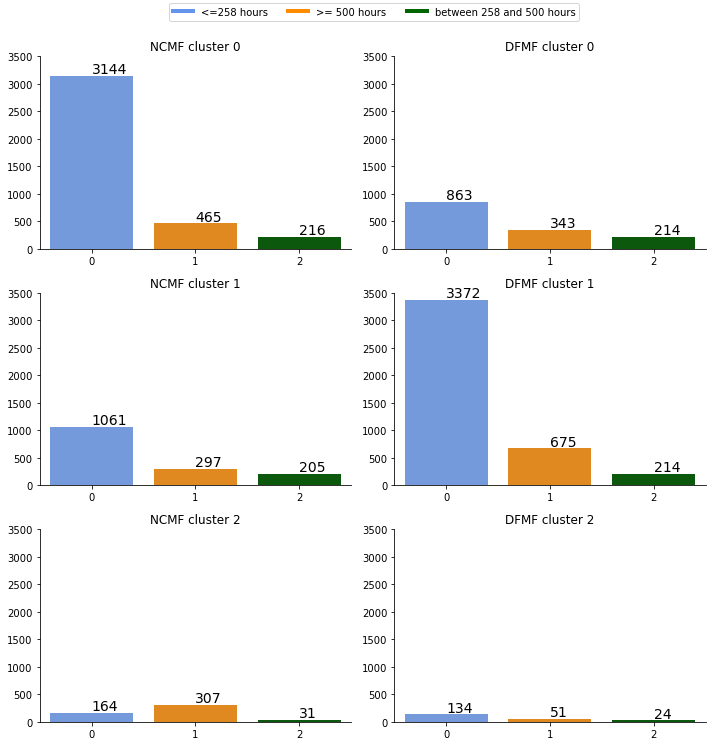

In [38]:
# ICU STAYS
fig, ax = plt.subplots(patient_clusters, 2, figsize=(10,10))
for i in range(patient_clusters):
    sns.barplot(x = list(tope_icu_ncmf[i].keys()), y = list(tope_icu_ncmf[i].values()), ax = ax[i][0], palette=palette)
    ax[i][0].set_title(f"NCMF cluster {i}")
    ax[i][0].set_ylim(0, 3500)
    x_list = list(sorted(tope_icu_ncmf[i].keys()))
    y_list = [tope_icu_ncmf[i][k] for k in x_list]
    for j in range(len(y_list)):
        ax[i][0].text(j, y_list[j]+50, str(y_list[j]), fontsize=14)
    ax[i][0].spines['top'].set_visible(False)
    ax[i][0].spines['right'].set_visible(False)
    sns.barplot(x = list(tope_icu_dfmf[i].keys()), y = list(tope_icu_dfmf[i].values()), ax = ax[i][1], palette=palette)
    ax[i][1].set_title(f"DFMF cluster {i}")
    ax[i][1].set_ylim(0, 3500)
    x_list = list(sorted(tope_icu_dfmf[i].keys()))
    y_list = [tope_icu_dfmf[i][k] for k in x_list]
    for j in range(len(y_list)):
        ax[i][1].text(j, y_list[j]+50, str(y_list[j]), fontsize=14)
    ax[i][1].spines['top'].set_visible(False)
    ax[i][1].spines['right'].set_visible(False)
fig.legend(custom_lines, ["<=258 hours", ">= 500 hours", "between 258 and 500 hours"],\
          bbox_to_anchor = (0.52,1.02), loc="center", ncol=3)
plt.tight_layout()
# plt.savefig("MIMIC_cluster_label_distribution.png", bbox_inches = "tight")

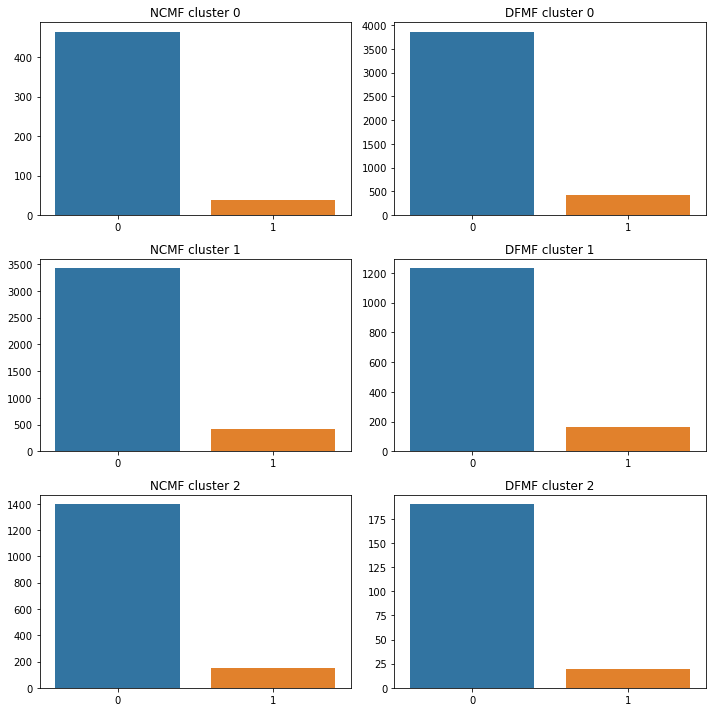

In [39]:
# ADMISSIONS
fig, ax = plt.subplots(patient_clusters, 2, figsize=(10,10))
for i in range(patient_clusters):
    sns.barplot(x = list(tope_adm_ncmf[i].keys()), y = list(tope_adm_ncmf[i].values()), ax = ax[i][0])
    ax[i][0].set_title(f"NCMF cluster {i}")
    sns.barplot(x = list(tope_adm_dfmf[i].keys()), y = list(tope_adm_dfmf[i].values()), ax = ax[i][1])
    ax[i][1].set_title(f"DFMF cluster {i}")
plt.tight_layout()

#### Step 6 - Score calculation - Silhouette, ARI

In [40]:
from sklearn.metrics import adjusted_rand_score, silhouette_score

In [41]:
# ICU stays
print(f"NCMF adjusted rand score = {adjusted_rand_score(icustays_df['LOS_category'], icustays_df['ncmf_clusters'])}")
print(f"DFMF adjusted rand score = {adjusted_rand_score(icustays_df['LOS_category'], icustays_df['dfmf_clusters'])}")
print(f"DCMF adjusted rand score = {adjusted_rand_score(icustays_df['LOS_category'], icustays_df['dcmf_clusters'])}")
print(f"CMF adjusted rand score = {adjusted_rand_score(icustays_df['LOS_category'], icustays_df['cmf_clusters'])}")
print(f"gCMF adjusted rand score = {adjusted_rand_score(icustays_df['LOS_category'], icustays_df['gcmf_clusters'])}")

NCMF adjusted rand score = 0.15205855180404174
DFMF adjusted rand score = 0.10596862605488676
DCMF adjusted rand score = 0.05970246205850106
CMF adjusted rand score = -0.00013876316157843311
gCMF adjusted rand score = 0.00019327515437802644


In [42]:
print(f"NCMF silhoeutte score for {patient_clusters} clusters = {silhouette_score(icustays_df[[f'emb_ncmf_{i}' for i in range(50)]], icustays_df['ncmf_clusters'])}")
print(f"DFMF silhoeutte score for {patient_clusters} clusters = {silhouette_score(icustays_df[[f'emb_dfmf_{i}' for i in range(50)]], icustays_df['dfmf_clusters'])}")

NCMF silhoeutte score for 3 clusters = 0.17392692771538784
DFMF silhoeutte score for 3 clusters = 0.6234033618683935


In [43]:
# Admissions
print(f"NCMF adjusted rand score = {adjusted_rand_score(admissions_df['HOSPITAL_EXPIRE_FLAG'], admissions_df['ncmf_clusters'])}")
print(f"DFMF adjusted rand score = {adjusted_rand_score(admissions_df['HOSPITAL_EXPIRE_FLAG'], admissions_df['dfmf_clusters'])}")

NCMF adjusted rand score = -0.012260050778181942
DFMF adjusted rand score = 0.009906618534747228


In [44]:
print(f"NCMF silhoeutte score for {patient_clusters} clusters = {silhouette_score(admissions_df[[f'emb_ncmf_{i}' for i in range(50)]], admissions_df['ncmf_clusters'])}")
print(f"DFMF silhoeutte score for {patient_clusters} clusters = {silhouette_score(admissions_df[[f'emb_dfmf_{i}' for i in range(50)]], admissions_df['dfmf_clusters'])}")

NCMF silhoeutte score for 3 clusters = 0.1743162217491196
DFMF silhoeutte score for 3 clusters = 0.6244042199154423


#### Step 7 - Visualize clusters using hypertools

/home/ajayago/anaconda3/envs/ncmf/lib/python3.7/site-packages/hypertools/plot/plot.py:250: UserWarning: Group will be deprecated. Please use hue keyword argument. See docs for details: http://hypertools.readthedocs.io/en/latest/hypertools.plot.html#hypertools.plot
  warnings.warn('Group will be deprecated. Please use '
/home/ajayago/anaconda3/envs/ncmf/lib/python3.7/site-packages/hypertools/plot/plot.py:250: UserWarning: Group will be deprecated. Please use hue keyword argument. See docs for details: http://hypertools.readthedocs.io/en/latest/hypertools.plot.html#hypertools.plot
  warnings.warn('Group will be deprecated. Please use '


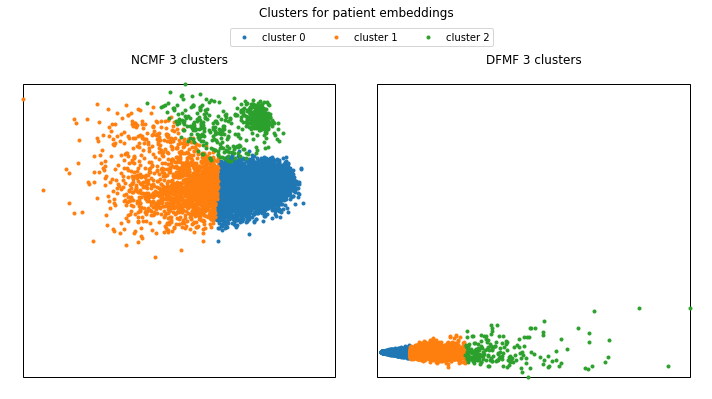

In [45]:
# ICU stays
fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle("Clusters for patient embeddings", y = 1.1)
hyp.plot(icustays_df[[f"emb_ncmf_{i}" for i in range(50)]], ".", group=icustays_df["ncmf_clusters"], ndims=2, title=f"NCMF {patient_clusters} clusters", ax=ax[0])
hyp.plot(icustays_df[[f"emb_dfmf_{i}" for i in range(50)]], ".", group=icustays_df["dfmf_clusters"], ndims=2, title=f"DFMF {patient_clusters} clusters", ax=ax[1], legend=list(icustays_df["dfmf_clusters"].unique()))
plt.legend(["cluster 0", "cluster 1", "cluster 2"], bbox_to_anchor = (0, 1.1), loc="center", ncol=4)
# plt.savefig("MIMIC_cluster_scatterplot.png", bbox_inches="tight")

/home/ajayago/anaconda3/envs/ncmf/lib/python3.7/site-packages/hypertools/plot/plot.py:250: UserWarning: Group will be deprecated. Please use hue keyword argument. See docs for details: http://hypertools.readthedocs.io/en/latest/hypertools.plot.html#hypertools.plot
  warnings.warn('Group will be deprecated. Please use '
/home/ajayago/anaconda3/envs/ncmf/lib/python3.7/site-packages/hypertools/plot/plot.py:250: UserWarning: Group will be deprecated. Please use hue keyword argument. See docs for details: http://hypertools.readthedocs.io/en/latest/hypertools.plot.html#hypertools.plot
  warnings.warn('Group will be deprecated. Please use '


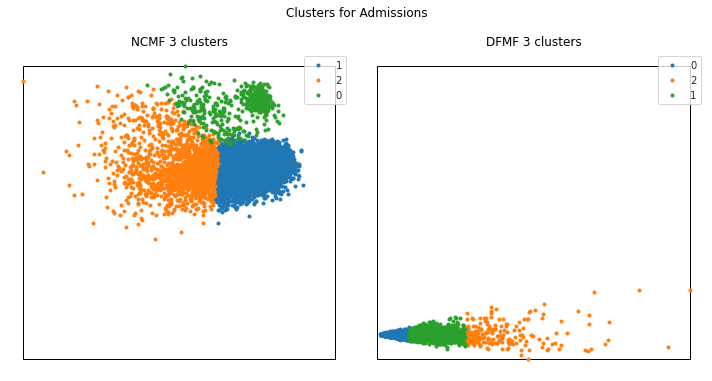

In [46]:
# Admissions - same plot as for ICU stays since entity in both cases are the patients
fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle("Clusters for Admissions", y = 1.05)
hyp.plot(admissions_df[[f"emb_ncmf_{i}" for i in range(50)]], ".", group=admissions_df["ncmf_clusters"], ndims=2, title=f"NCMF {patient_clusters} clusters", ax=ax[0], legend=list(admissions_df["ncmf_clusters"].unique()))
hyp.plot(admissions_df[[f"emb_dfmf_{i}" for i in range(50)]], ".", group=admissions_df["dfmf_clusters"], ndims=2, title=f"DFMF {patient_clusters} clusters", ax=ax[1], legend=list(admissions_df["dfmf_clusters"].unique()))

#### Step 8 - Visualize actual labels

/home/ajayago/anaconda3/envs/ncmf/lib/python3.7/site-packages/hypertools/plot/plot.py:250: UserWarning: Group will be deprecated. Please use hue keyword argument. See docs for details: http://hypertools.readthedocs.io/en/latest/hypertools.plot.html#hypertools.plot
  warnings.warn('Group will be deprecated. Please use '
/home/ajayago/anaconda3/envs/ncmf/lib/python3.7/site-packages/hypertools/plot/plot.py:250: UserWarning: Group will be deprecated. Please use hue keyword argument. See docs for details: http://hypertools.readthedocs.io/en/latest/hypertools.plot.html#hypertools.plot
  warnings.warn('Group will be deprecated. Please use '


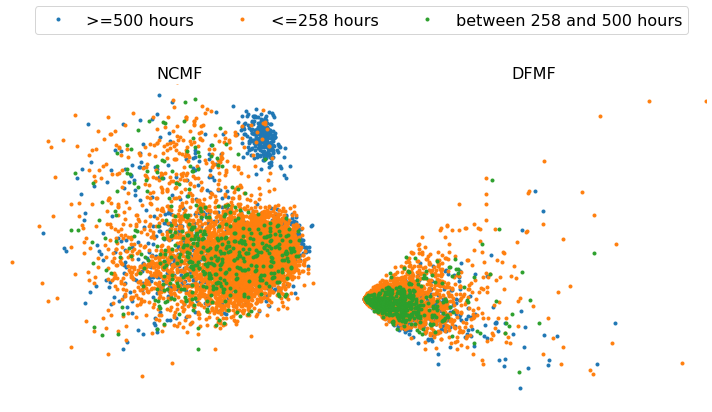

In [47]:
# ICU stays
fig, ax = plt.subplots(1, 2, figsize=(10,5))
# fig.suptitle("Existing labels for ICU stays - LOS category", y = 1.1)
fig.subplots_adjust(left=0, right=0.75, bottom =0, top=0.75, wspace=0, hspace=0)

hyp.plot(icustays_df[[f"emb_ncmf_{i}" for i in range(50)]], ".", group=icustays_df["LOS_category"], ndims=2, ax=ax[0], show=False)
ax[0].set_title("NCMF", fontsize=16)
ax[0].set_ylim(-0.3,0.99)
ax[0].set_xlim(-0.9, 1)
hyp.plot(icustays_df[[f"emb_dfmf_{i}" for i in range(50)]], ".", group=icustays_df["LOS_category"], ndims=2, ax=ax[1], legend=list(icustays_df["LOS_category"].unique()))
ax[1].set_title("DFMF", fontsize=16)
ax[1].set_ylim(-0.99, -0.5)
ax[1].set_xlim(-0.99, 1)


plt.legend([">=500 hours", "<=258 hours", "between 258 and 500 hours"], bbox_to_anchor = (0, 1.2), loc="center", ncol=4, fontsize=16)
# plt.savefig("MIMIC_actual_label_scatterplot.png", bbox_inches="tight")

/home/ajayago/anaconda3/envs/ncmf/lib/python3.7/site-packages/hypertools/plot/plot.py:250: UserWarning: Group will be deprecated. Please use hue keyword argument. See docs for details: http://hypertools.readthedocs.io/en/latest/hypertools.plot.html#hypertools.plot
  warnings.warn('Group will be deprecated. Please use '
/home/ajayago/anaconda3/envs/ncmf/lib/python3.7/site-packages/hypertools/plot/plot.py:250: UserWarning: Group will be deprecated. Please use hue keyword argument. See docs for details: http://hypertools.readthedocs.io/en/latest/hypertools.plot.html#hypertools.plot
  warnings.warn('Group will be deprecated. Please use '


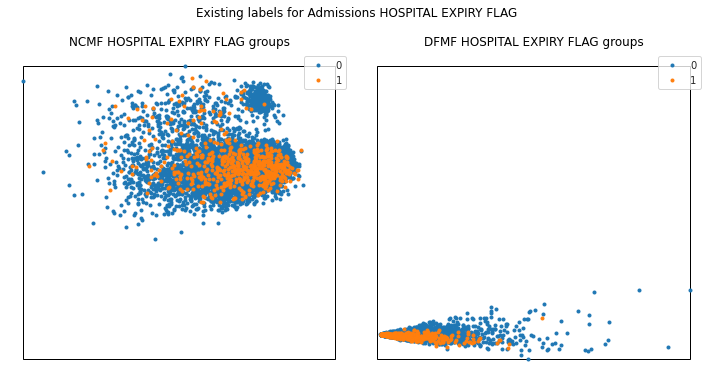

In [48]:
# Admissions
fig, ax = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle("Existing labels for Admissions HOSPITAL EXPIRY FLAG", y = 1.05)
hyp.plot(admissions_df[[f"emb_ncmf_{i}" for i in range(50)]], ".", group=admissions_df["HOSPITAL_EXPIRE_FLAG"], ndims=2, title=f"NCMF HOSPITAL EXPIRY FLAG groups", ax=ax[0], legend=list(admissions_df["HOSPITAL_EXPIRE_FLAG"].unique()))
hyp.plot(admissions_df[[f"emb_dfmf_{i}" for i in range(50)]], ".", group=admissions_df["HOSPITAL_EXPIRE_FLAG"], ndims=2, title=f"DFMF HOSPITAL EXPIRY FLAG groups", ax=ax[1], legend=list(admissions_df["HOSPITAL_EXPIRE_FLAG"].unique()))